In [2]:
from torchvision import models, transforms
from torchsummary import summary
import torch
import numpy as np
import cv2
import PIL
import matplotlib.pyplot as plt

import sys
import os

current_dir = os.getcwd()
sys.path.append(os.path.dirname(current_dir))

from lib.src import *
from lib.utils import *

from pytorch_grad_cam import GradCAM, HiResCAM, AblationCAM, ScoreCAM, GradCAMPlusPlus, XGradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision.models import resnet50

In [2]:
X = [0.01, 0.05, 0.1, 0.25, 0.5]
CAM_X_AD = [0.025, 0.065, 0.109, 0.227, 0.373]
CAM_X_RIS = [0.387, 0.293, 0.239, 0.130, 0.056]

GRADCAM_X_AD =[0.062, 0.096, 0.120, 0.201, 0.379]
GRADCAM_X_RIS = [0.357, 0.306, 0.252, 0.179, 0.065]

HIRESCAM_X_AD = [0.043, 0.088, 0.144, 0.241, 0.388]
HIRESCAM_X_RIS = [0.401, 0.304, 0.226, 0.162, 0.063]

ABLATIONCAM_X_AD = [0.092, 0.076, 0.161, 0.290, 0.270]
ABLATIONCAM_X_RIS = [0.200, 0.400, 0.200, 0.000, 0.000]

XGRADCAM_X_AD = [0.172, 0.217, 0.257, 0.356, 0.444]
XGRADCAM_X_RIS = [0.187, 0.164, 0.105, 0.077, 0.029]

GRADCAMPLUSPLUS_X_AD = [0.098, 0.137, 0.156, 0.248, 0.383]
GRADCAMPLUSPLUS_X_RIS = [0.279, 0.206, 0.202, 0.135, 0.051]

SCORECAM_X_AD = [0.135, 0.291, 0.238, 0.449, 0.504]
SCORECAM_X_RIS = [0.0, 0.0, 0.0, 0.0, 0.0]

In [3]:
import matplotlib.pyplot as plt
import numpy as np

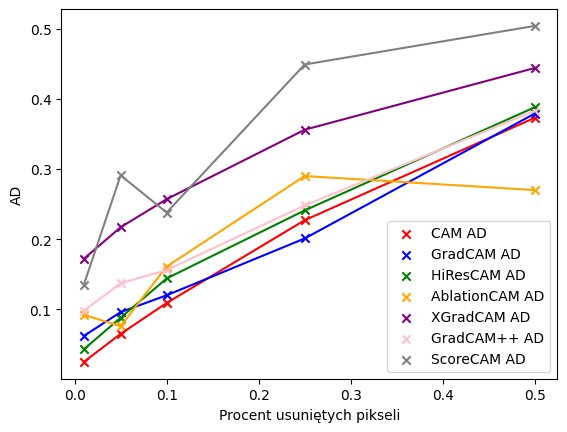

In [4]:
plt.scatter(X, CAM_X_AD, label='CAM AD', color='red', marker='x')
plt.scatter(X, GRADCAM_X_AD, label='GradCAM AD', color='blue', marker='x')
plt.scatter(X, HIRESCAM_X_AD, label='HiResCAM AD', color='green', marker='x')
plt.scatter(X, ABLATIONCAM_X_AD, label='AblationCAM AD', color='orange', marker='x')
plt.scatter(X, XGRADCAM_X_AD, label='XGradCAM AD', color='purple', marker='x')
plt.scatter(X, GRADCAMPLUSPLUS_X_AD, label='GradCAM++ AD', color='pink', marker='x')
plt.scatter(X, SCORECAM_X_AD, label='ScoreCAM AD', color='grey', marker='x')

plt.plot(X, CAM_X_AD, color='red')
plt.plot(X, GRADCAM_X_AD, color='blue')
plt.plot(X, HIRESCAM_X_AD, color='green')
plt.plot(X, ABLATIONCAM_X_AD, color='orange')
plt.plot(X, XGRADCAM_X_AD, color='purple')
plt.plot(X, GRADCAMPLUSPLUS_X_AD, color='pink')
plt.plot(X, SCORECAM_X_AD, color='grey')

plt.legend()

plt.xlabel('Procent usuniętych pikseli')
plt.ylabel('AD')

plt.savefig('pres/AD.png')
plt.show()

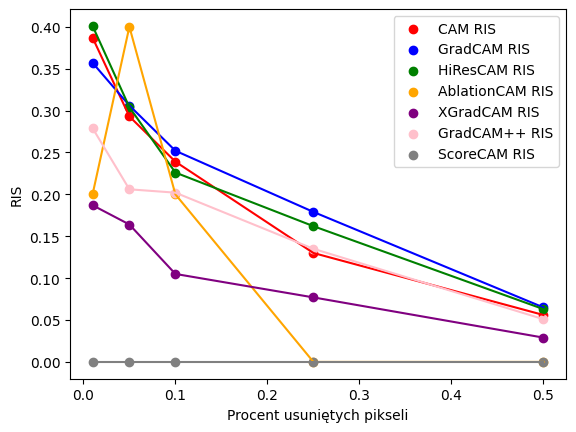

In [5]:
plt.scatter(X, CAM_X_RIS, label='CAM RIS', color='red', marker='o')
plt.scatter(X, GRADCAM_X_RIS, label='GradCAM RIS', color='blue', marker='o')
plt.scatter(X, HIRESCAM_X_RIS, label='HiResCAM RIS', color='green', marker='o')
plt.scatter(X, ABLATIONCAM_X_RIS, label='AblationCAM RIS', color='orange', marker='o')
plt.scatter(X, XGRADCAM_X_RIS, label='XGradCAM RIS', color='purple', marker='o')
plt.scatter(X, GRADCAMPLUSPLUS_X_RIS, label='GradCAM++ RIS', color='pink', marker='o')
plt.scatter(X, SCORECAM_X_RIS, label='ScoreCAM RIS', color='grey', marker='o')

plt.plot(X, CAM_X_RIS, color='red')
plt.plot(X, GRADCAM_X_RIS, color='blue')
plt.plot(X, HIRESCAM_X_RIS, color='green')
plt.plot(X, ABLATIONCAM_X_RIS, color='orange')
plt.plot(X, XGRADCAM_X_RIS, color='purple')
plt.plot(X, GRADCAMPLUSPLUS_X_RIS, color='pink')
plt.plot(X, SCORECAM_X_RIS, color='grey')

plt.legend()

plt.xlabel('Procent usuniętych pikseli')
plt.ylabel('RIS')

plt.savefig('pres/RIS.png')
plt.show()

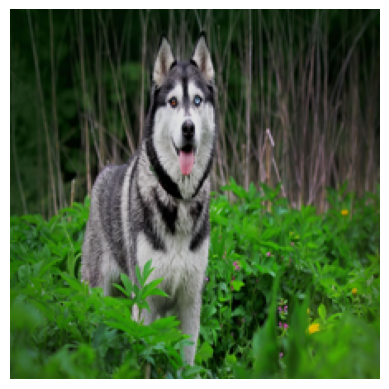

In [6]:
husky = get_image_torch("images/husky.jpg", 224, 224)
plt.imshow(husky.permute(1, 2, 0))
plt.axis('off')
plt.show()

c:\Users\kniko\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\kniko\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


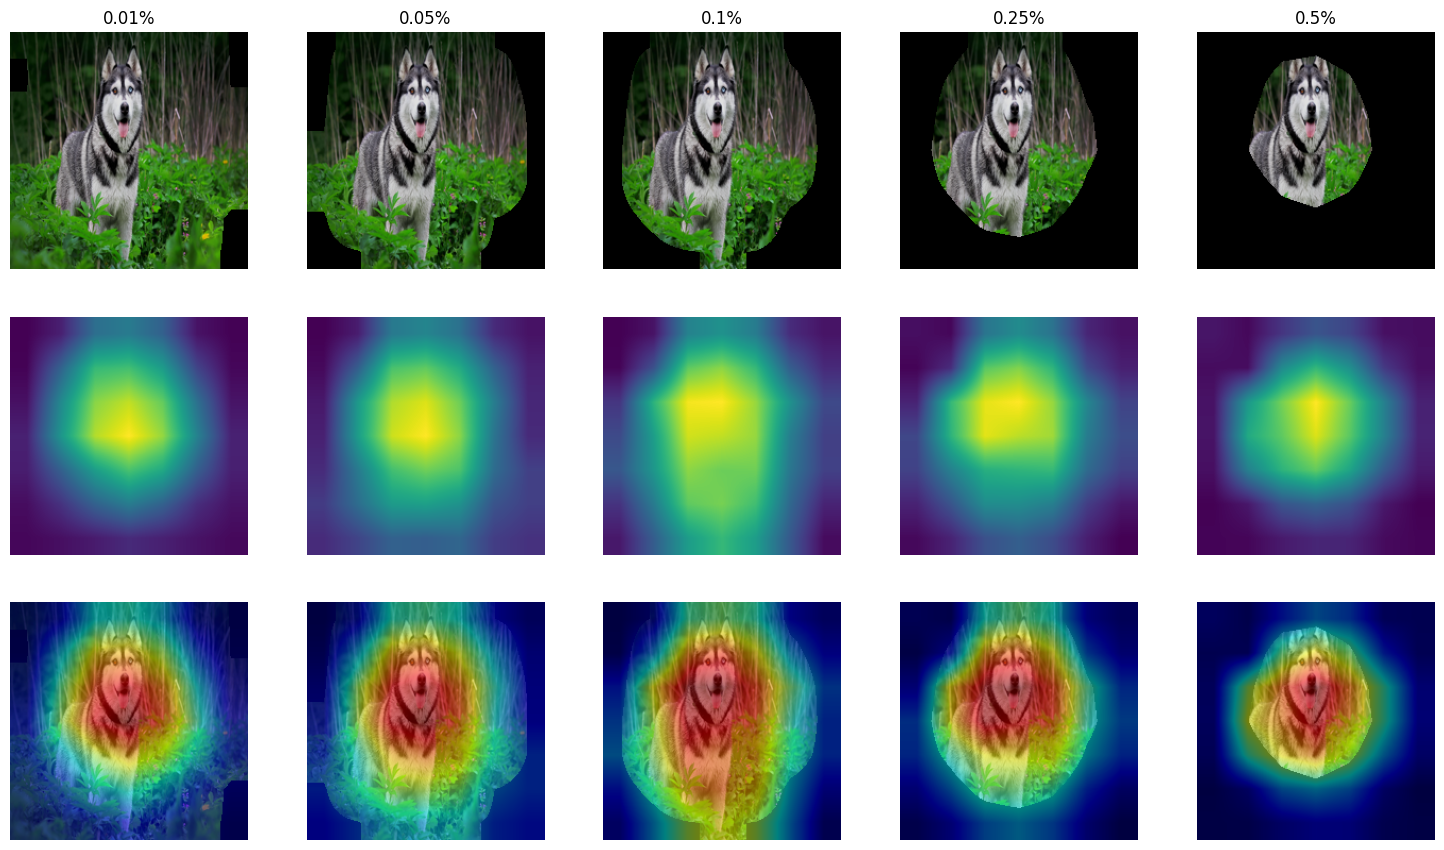

In [7]:
PERCENTAGES = [0.01, 0.05, 0.1, 0.25, 0.5]
MODEL = resnet50(pretrained=True)
TARGET_LAYER = MODEL.layer4[-1].conv3
CLASS = 250
FUNCTION = get_cam
IMAGE = get_image_torch("images/husky.jpg", 224, 224)

fig, axs = plt.subplots(3, 5)
fig.set_size_inches(18.5, 10.5)


CAM = None

for i, percentage in enumerate(PERCENTAGES):
    if CAM is None:
        CAM = FUNCTION(IMAGE, MODEL, TARGET_LAYER, CLASS)
    IMG_DEL = delete_the_least_important_pixels(IMAGE, CAM, percentage)
    axs[0, i].imshow(IMG_DEL.permute(1, 2, 0))
    axs[0, i].axis('off')
    axs[0, i].set_title(f"{percentage}%")

    CAM_DEL = FUNCTION(IMG_DEL, MODEL, TARGET_LAYER, CLASS)

    CAM_DEL_TO_SHOW = cv2.resize(CAM_DEL, (224, 224))


    axs[1, i].imshow(CAM_DEL_TO_SHOW)
    axs[1, i].axis('off')

    IMG_OVERLAY_DEL = get_overlay(IMG_DEL, CAM_DEL, 0.5)
    axs[2, i].imshow(IMG_OVERLAY_DEL)
    axs[2, i].axis('off')

plt.savefig('pres/cam.png')
plt.show()

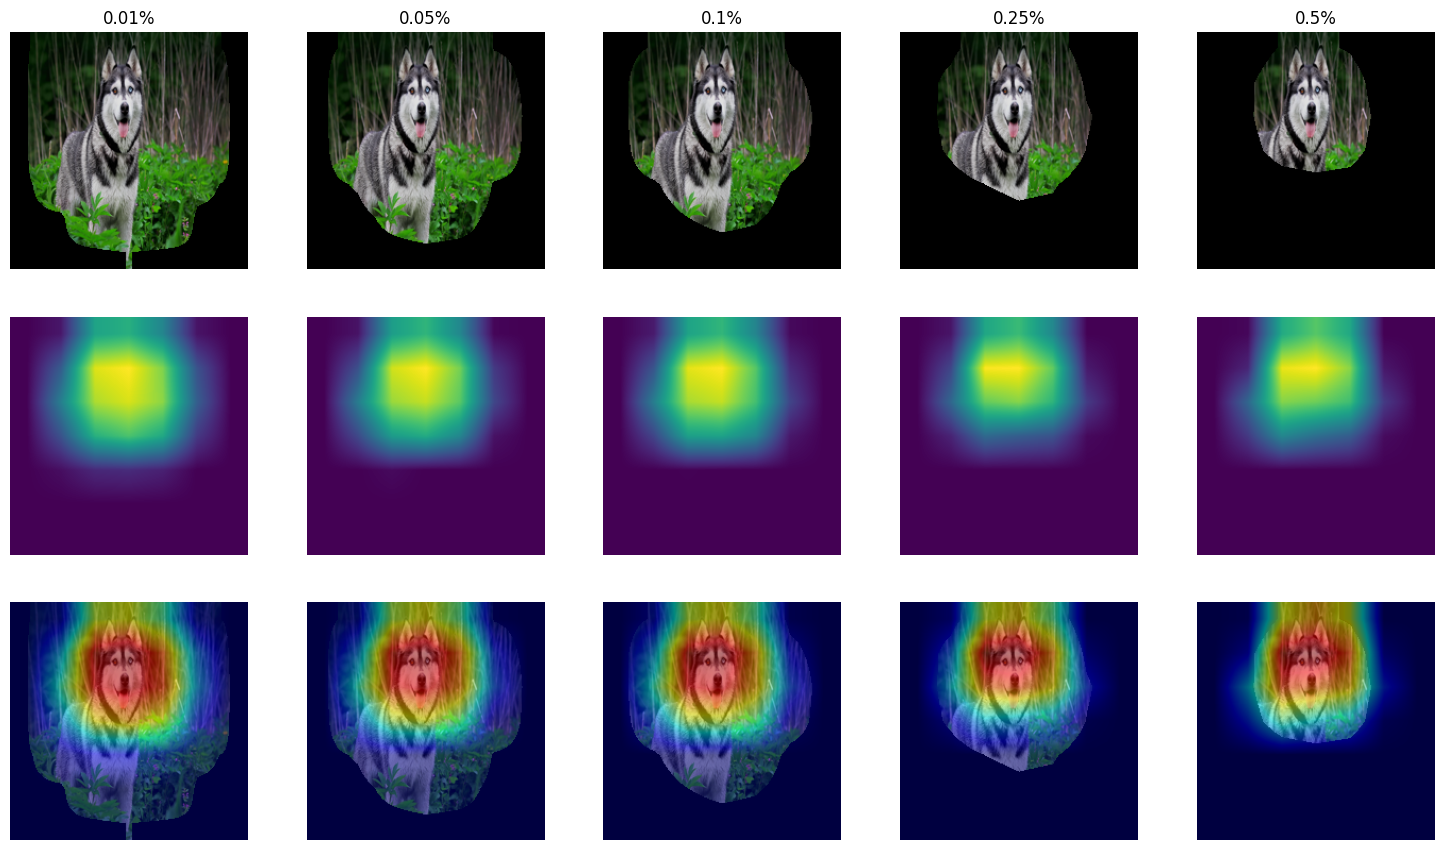

In [8]:
PERCENTAGES = [0.01, 0.05, 0.1, 0.25, 0.5]
MODEL = resnet50(pretrained=True)
TARGET_LAYER = MODEL.layer4[-1].conv3
CLASS = 250
FUNCTION = get_gradcam
IMAGE = get_image_torch("images/husky.jpg", 224, 224)

fig, axs = plt.subplots(3, 5)
fig.set_size_inches(18.5, 10.5)


CAM = None

for i, percentage in enumerate(PERCENTAGES):
    if CAM is None:
        CAM = FUNCTION(IMAGE, MODEL, TARGET_LAYER, CLASS)
    IMG_DEL = delete_the_least_important_pixels(IMAGE, CAM, percentage)
    axs[0, i].imshow(IMG_DEL.permute(1, 2, 0))
    axs[0, i].axis('off')
    axs[0, i].set_title(f"{percentage}%")

    CAM_DEL = FUNCTION(IMG_DEL, MODEL, TARGET_LAYER, CLASS)

    CAM_DEL_TO_SHOW = cv2.resize(CAM_DEL, (224, 224))


    axs[1, i].imshow(CAM_DEL_TO_SHOW)
    axs[1, i].axis('off')

    IMG_OVERLAY_DEL = get_overlay(IMG_DEL, CAM_DEL, 0.5)
    axs[2, i].imshow(IMG_OVERLAY_DEL)
    axs[2, i].axis('off')

plt.savefig('pres/gradcam.png')
plt.show()

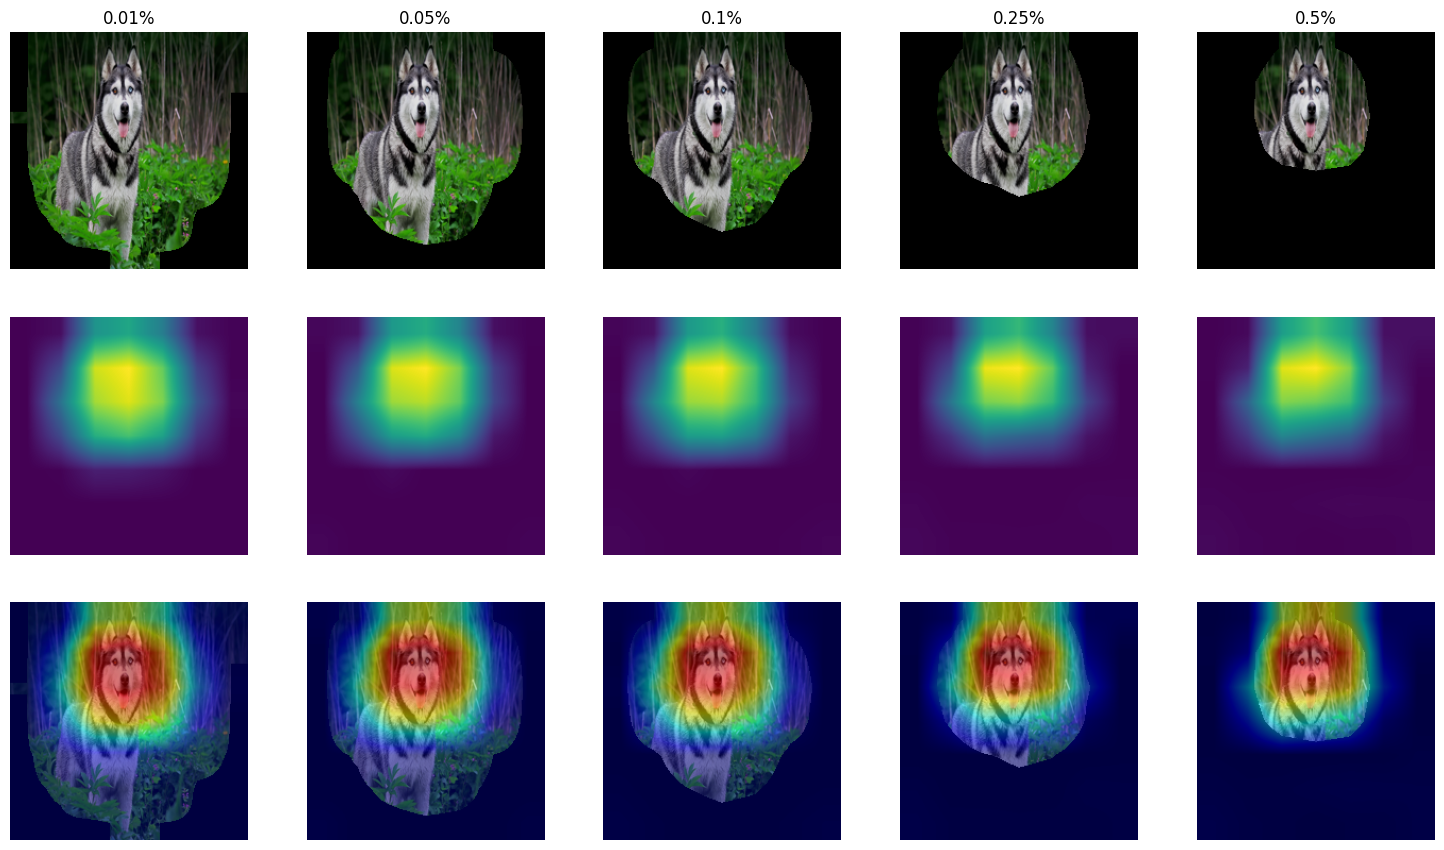

In [9]:
PERCENTAGES = [0.01, 0.05, 0.1, 0.25, 0.5]
MODEL = resnet50(pretrained=True)
TARGET_LAYER = MODEL.layer4[-1].conv3
CLASS = 250
FUNCTION = get_hirescam
IMAGE = get_image_torch("images/husky.jpg", 224, 224)

fig, axs = plt.subplots(3, 5)
fig.set_size_inches(18.5, 10.5)


CAM = None

for i, percentage in enumerate(PERCENTAGES):
    if CAM is None:
        CAM = FUNCTION(IMAGE, MODEL, TARGET_LAYER, CLASS)
    IMG_DEL = delete_the_least_important_pixels(IMAGE, CAM, percentage)
    axs[0, i].imshow(IMG_DEL.permute(1, 2, 0))
    axs[0, i].axis('off')
    axs[0, i].set_title(f"{percentage}%")

    CAM_DEL = FUNCTION(IMG_DEL, MODEL, TARGET_LAYER, CLASS)

    CAM_DEL_TO_SHOW = cv2.resize(CAM_DEL, (224, 224))


    axs[1, i].imshow(CAM_DEL_TO_SHOW)
    axs[1, i].axis('off')

    IMG_OVERLAY_DEL = get_overlay(IMG_DEL, CAM_DEL, 0.5)
    axs[2, i].imshow(IMG_OVERLAY_DEL)
    axs[2, i].axis('off')

plt.savefig('pres/hirescam.png')
plt.show()

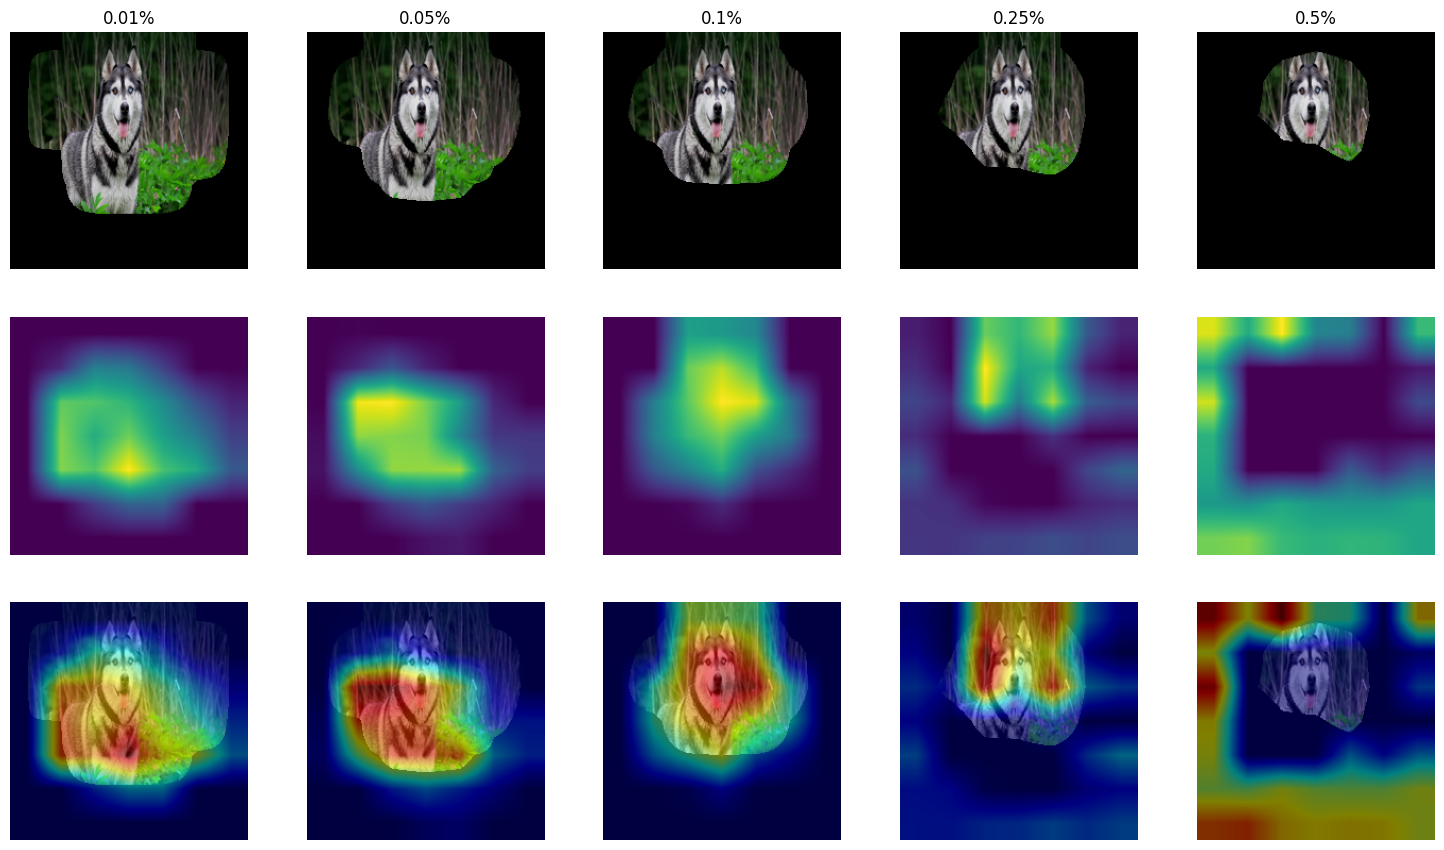

In [10]:
PERCENTAGES = [0.01, 0.05, 0.1, 0.25, 0.5]
MODEL = resnet50(pretrained=True)
TARGET_LAYER = MODEL.layer4[-1].conv3
CLASS = 250
FUNCTION = get_xgradcam
IMAGE = get_image_torch("images/husky.jpg", 224, 224)

fig, axs = plt.subplots(3, 5)
fig.set_size_inches(18.5, 10.5)


CAM = None

for i, percentage in enumerate(PERCENTAGES):
    if CAM is None:
        CAM = FUNCTION(IMAGE, MODEL, TARGET_LAYER, CLASS)
    IMG_DEL = delete_the_least_important_pixels(IMAGE, CAM, percentage)
    axs[0, i].imshow(IMG_DEL.permute(1, 2, 0))
    axs[0, i].axis('off')
    axs[0, i].set_title(f"{percentage}%")

    CAM_DEL = FUNCTION(IMG_DEL, MODEL, TARGET_LAYER, CLASS)

    CAM_DEL_TO_SHOW = cv2.resize(CAM_DEL, (224, 224))


    axs[1, i].imshow(CAM_DEL_TO_SHOW)
    axs[1, i].axis('off')

    IMG_OVERLAY_DEL = get_overlay(IMG_DEL, CAM_DEL, 0.5)
    axs[2, i].imshow(IMG_OVERLAY_DEL)
    axs[2, i].axis('off')

plt.savefig('pres/xgradcam.png')
plt.show()

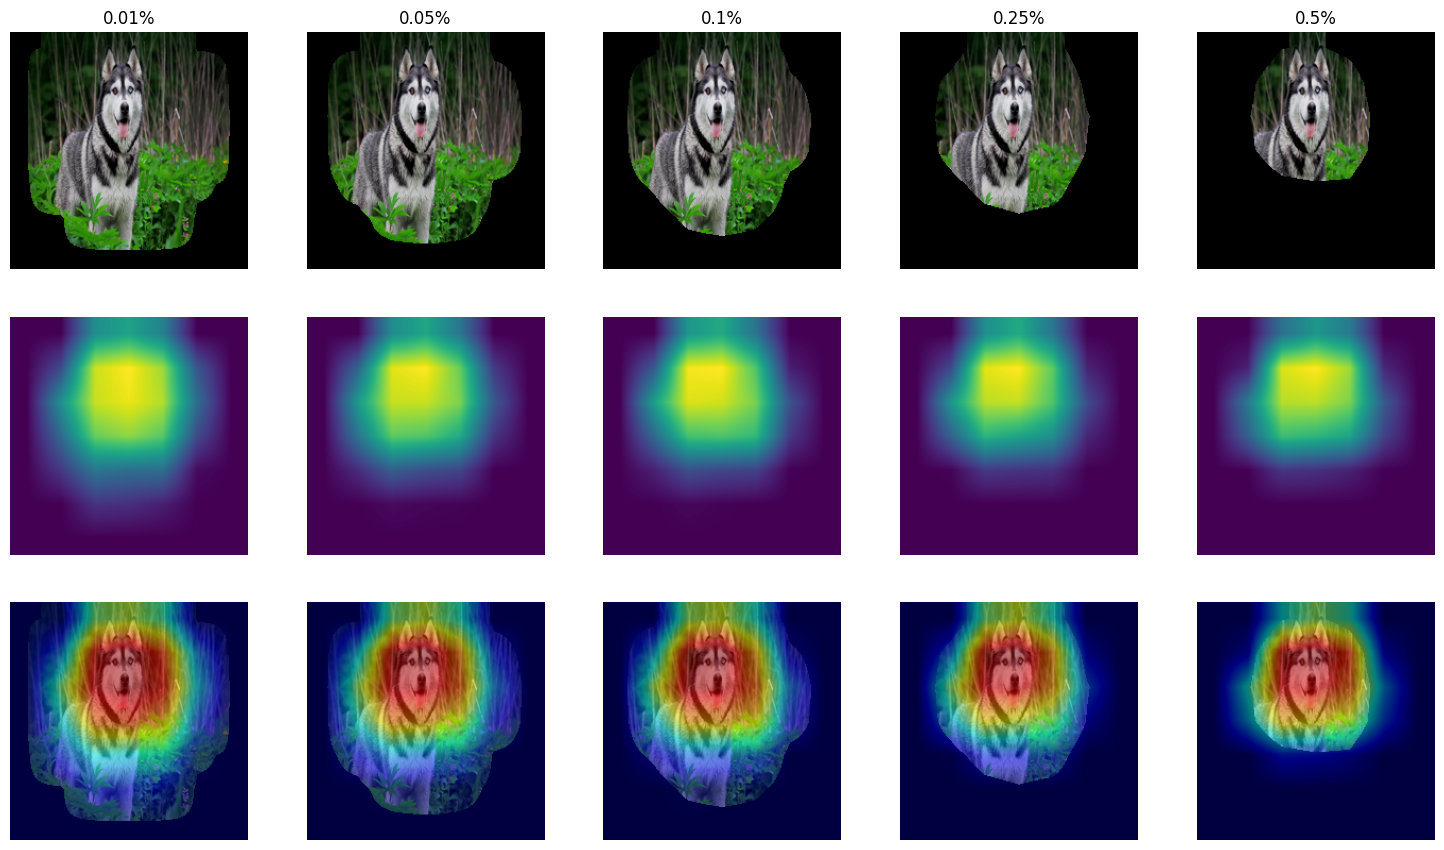

In [11]:
PERCENTAGES = [0.01, 0.05, 0.1, 0.25, 0.5]
MODEL = resnet50(pretrained=True)
TARGET_LAYER = MODEL.layer4[-1].conv3
CLASS = 250
FUNCTION = get_gradcamplusplus
IMAGE = get_image_torch("images/husky.jpg", 224, 224)

fig, axs = plt.subplots(3, 5)
fig.set_size_inches(18.5, 10.5)


CAM = None

for i, percentage in enumerate(PERCENTAGES):
    if CAM is None:
        CAM = FUNCTION(IMAGE, MODEL, TARGET_LAYER, CLASS)
    IMG_DEL = delete_the_least_important_pixels(IMAGE, CAM, percentage)
    axs[0, i].imshow(IMG_DEL.permute(1, 2, 0))
    axs[0, i].axis('off')
    axs[0, i].set_title(f"{percentage}%")

    CAM_DEL = FUNCTION(IMG_DEL, MODEL, TARGET_LAYER, CLASS)

    CAM_DEL_TO_SHOW = cv2.resize(CAM_DEL, (224, 224))


    axs[1, i].imshow(CAM_DEL_TO_SHOW)
    axs[1, i].axis('off')

    IMG_OVERLAY_DEL = get_overlay(IMG_DEL, CAM_DEL, 0.5)
    axs[2, i].imshow(IMG_OVERLAY_DEL)
    axs[2, i].axis('off')

plt.savefig('pres/gradcamplusplus.png')
plt.show()

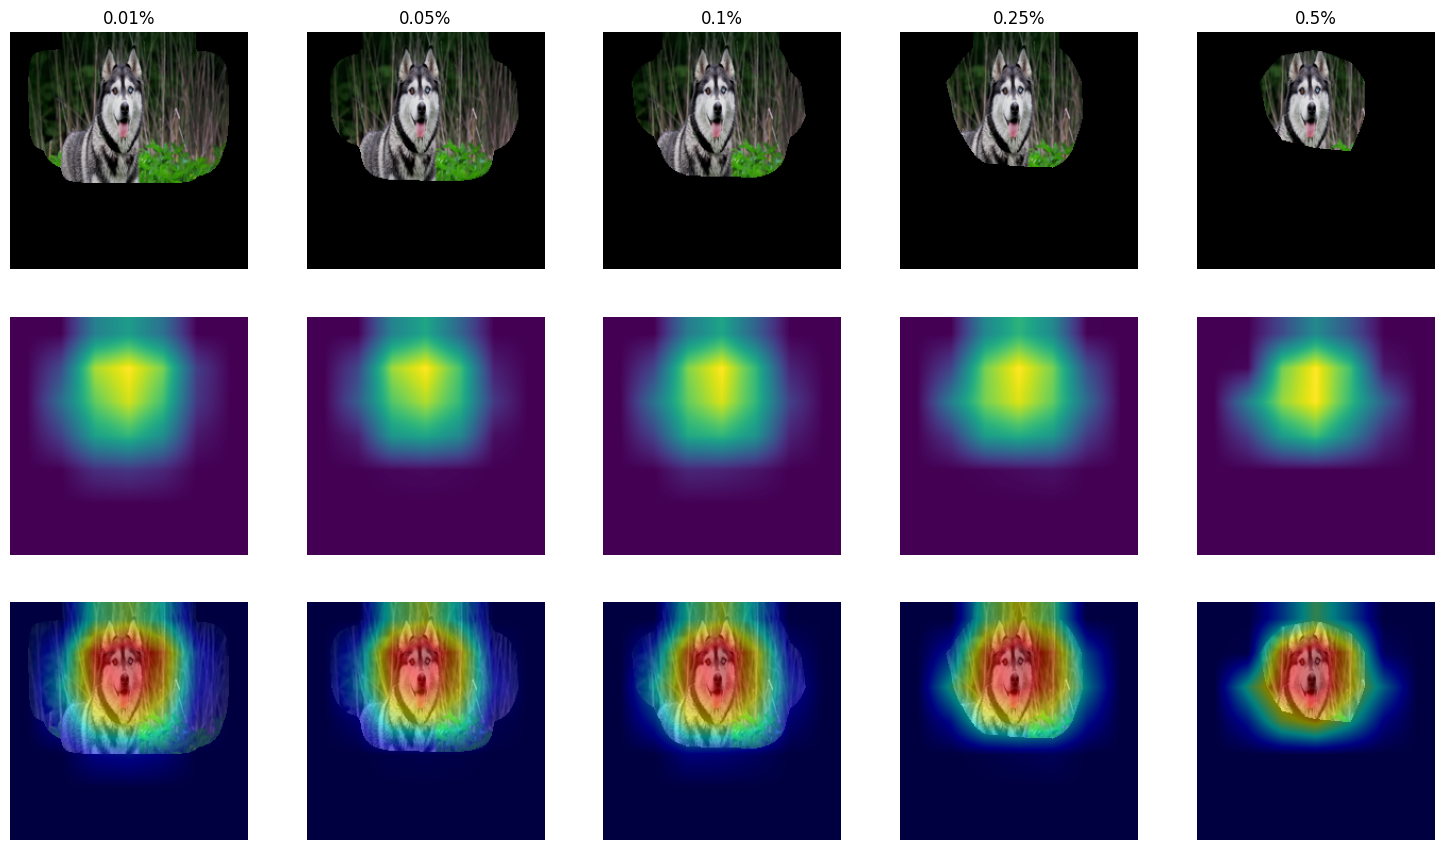

In [12]:
PERCENTAGES = [0.01, 0.05, 0.1, 0.25, 0.5]
MODEL = resnet50(pretrained=True)
TARGET_LAYER = MODEL.layer4[-1].conv3
CLASS = 250
FUNCTION = get_scorecam
IMAGE = get_image_torch("images/husky.jpg", 224, 224)

fig, axs = plt.subplots(3, 5)
fig.set_size_inches(18.5, 10.5)


CAM = None

for i, percentage in enumerate(PERCENTAGES):
    if CAM is None:
        CAM = FUNCTION(IMAGE, MODEL, TARGET_LAYER, CLASS)
    IMG_DEL = delete_the_least_important_pixels(IMAGE, CAM, percentage)
    axs[0, i].imshow(IMG_DEL.permute(1, 2, 0))
    axs[0, i].axis('off')
    axs[0, i].set_title(f"{percentage}%")

    CAM_DEL = FUNCTION(IMG_DEL, MODEL, TARGET_LAYER, CLASS)

    CAM_DEL_TO_SHOW = cv2.resize(CAM_DEL, (224, 224))


    axs[1, i].imshow(CAM_DEL_TO_SHOW)
    axs[1, i].axis('off')

    IMG_OVERLAY_DEL = get_overlay(IMG_DEL, CAM_DEL, 0.5)
    axs[2, i].imshow(IMG_OVERLAY_DEL)
    axs[2, i].axis('off')

plt.savefig('pres/scorecam.png')
plt.show()

c:\Users\kniko\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\kniko\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


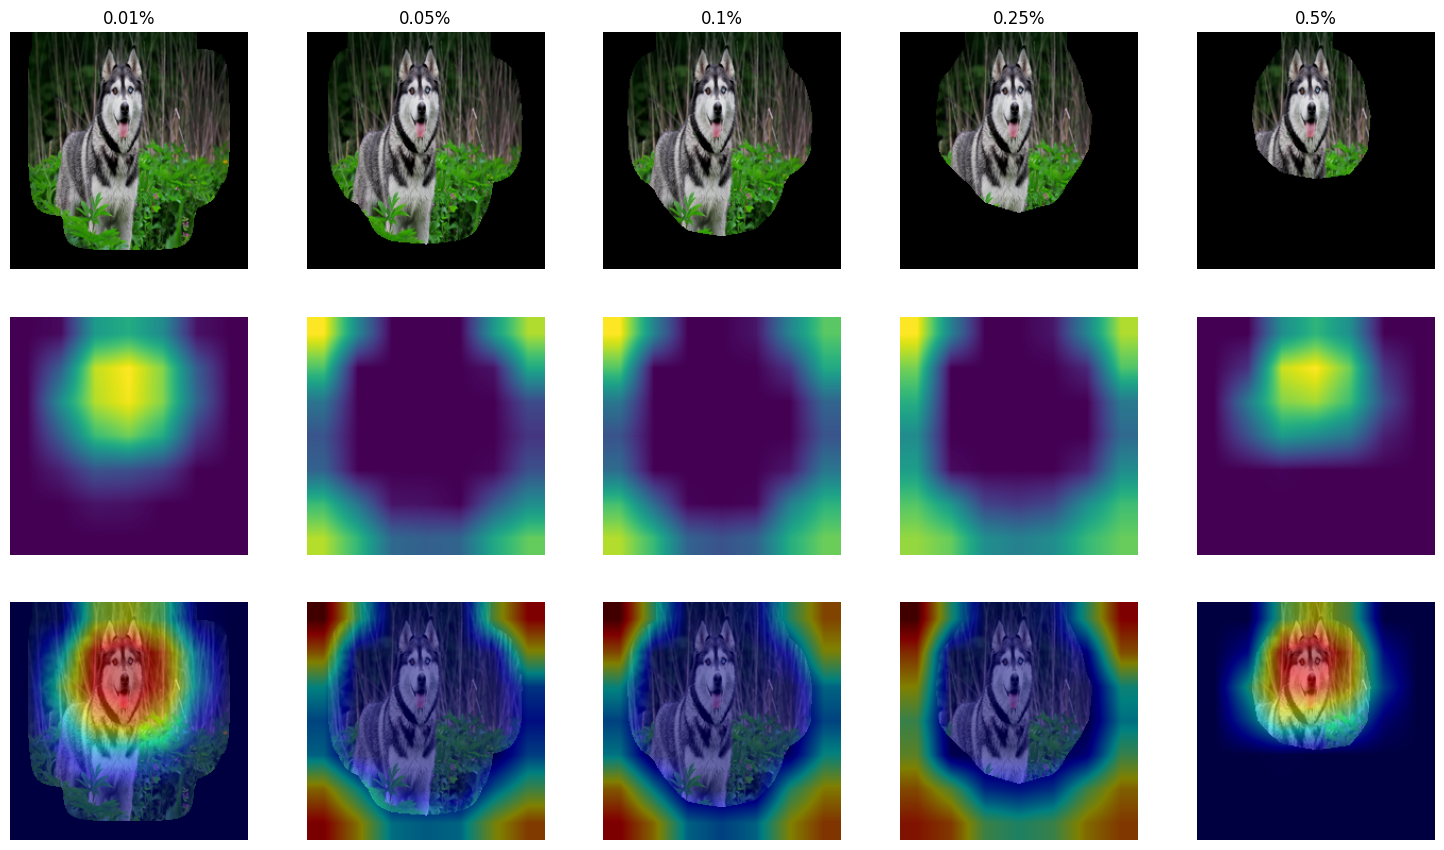

In [3]:
PERCENTAGES = [0.01, 0.05, 0.1, 0.25, 0.5]
MODEL = resnet50(pretrained=True)
TARGET_LAYER = MODEL.layer4[-1].conv3
CLASS = 250
FUNCTION = get_ablationcam
IMAGE = get_image_torch("images/husky.jpg", 224, 224)

fig, axs = plt.subplots(3, 5)
fig.set_size_inches(18.5, 10.5)


CAM = None

for i, percentage in enumerate(PERCENTAGES):
    if CAM is None:
        CAM = FUNCTION(IMAGE, MODEL, TARGET_LAYER, CLASS)
    IMG_DEL = delete_the_least_important_pixels(IMAGE, CAM, percentage)
    axs[0, i].imshow(IMG_DEL.permute(1, 2, 0))
    axs[0, i].axis('off')
    axs[0, i].set_title(f"{percentage}%")

    CAM_DEL = FUNCTION(IMG_DEL, MODEL, TARGET_LAYER, CLASS)

    CAM_DEL_TO_SHOW = cv2.resize(CAM_DEL, (224, 224))


    axs[1, i].imshow(CAM_DEL_TO_SHOW)
    axs[1, i].axis('off')

    IMG_OVERLAY_DEL = get_overlay(IMG_DEL, CAM_DEL, 0.5)
    axs[2, i].imshow(IMG_OVERLAY_DEL)
    axs[2, i].axis('off')

plt.savefig('pres/ablationcam.png')
plt.show()